In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import collections
from bs4 import BeautifulSoup
from datetime import datetime
from plotnine import *
from mizani.formatters import percent_format

## **Unindo os datasets**

In [3]:
# bechdel_df = pd.read_csv('datasets/Bechdel_detailed.csv')
# links_df = pd.read_csv('datasets/movie-dataset/links.csv') # contém o id do imdb e tmdb de cada filme

# # remove colunas não usadas
# bechdel_df = bechdel_df.drop(['Unnamed: 0', 'submitterid', 'date', 'visible', 'id'], axis=1)

# # renomeia rating para não coincidir com o dos outros datasets
# bechdel_df = bechdel_df.rename(columns={'rating': 'bt_score'})

# # junta os 3 dataframes e descarta colunas duplicadas
# bechdel_df = pd.merge(bechdel_df, links_df, left_on='imdbid', right_on='imdbId', how='inner').drop(['imdbId', 'movieId'], axis=1)

# bechdel_df.head()

In [4]:
# bechdel_df = bechdel_df.sort_values(by=['bt_score', 'year'], ascending=[False, True]).reset_index(drop=True)
# bechdel_df.head()

## **Tratamento dos dados**

### **Retirada de nulos**

In [5]:
# bechdel_df.describe()

In [6]:
# data = bechdel_df.dropna().copy()

In [7]:
# data.describe()

### **Transformando tipos de dados**

In [8]:
# data['year'] = data['year'].astype('int')
# data['bt_score'] = data['bt_score'].astype('int')
# data['dubious'] = data['dubious'].astype('int')
# data['imdbid'] = data['imdbid'].astype('int')
# data['tmdbId'] = data['tmdbId'].astype('int')

### **API**

##### **Raspar dados dos filmes**

In [9]:
# data['genres'] = pd.NA
# data['popularity'] = pd.NA
# data['production_companies'] = pd.NA
# data['production_countries'] = pd.NA
# data['release_date'] = pd.NA
# data['revenue'] = pd.NA
# data['title'] = pd.NA
# data['vote_average'] = pd.NA
# data['vote_count'] = pd.NA
# data['cast'] = pd.NA
# data['crew'] = pd.NA

In [10]:
# api_key = 'b12a91c6b0aa37015f0b966b61efd74d'

# for index, row in data.iterrows():
#     try:
#         info = requests.get(f'https://api.themoviedb.org/3/movie/{row["tmdbId"]}?api_key={api_key}')
#         credits = requests.get(f'https://api.themoviedb.org/3/movie/{row["tmdbId"]}/credits?api_key={api_key}')
        
#         details = info.json()
#         details['cast'] = credits.json()['cast']
#         details['crew'] = credits.json()['crew']

#         data.loc[index, 'budget'] = details['budget']
#         data.loc[index, 'genres'] = str(details['genres'])
#         data.loc[index, 'popularity'] = details['popularity']
#         data.loc[index, 'production_companies'] = str(details['production_companies'])
#         data.loc[index, 'production_countries'] = str(details['production_countries'])
#         data.loc[index, 'release_date'] = details['release_date']
#         data.loc[index, 'revenue'] = details['revenue']
#         data.loc[index, 'title'] = details['title']
#         data.loc[index, 'vote_average'] = details['vote_average']
#         data.loc[index, 'vote_count'] = details['vote_count']
#         data.loc[index, 'cast'] = str(details['cast'])
#         data.loc[index, 'crew'] = str(details['crew'])
#     except:
#         print(row['tmdbId'])

# data.to_csv('api_data.csv')

In [11]:
data = pd.read_csv('api_data.csv', index_col=0)

data = data.dropna().copy()

data.head()

,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,release_date,revenue,vote_average,vote_count,cast,crew,budget
0,Cinderella,1899,3,0,230,114108,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",3.762,"[{'id': 7159, 'logo_path': None, 'name': 'Star...","[{'iso_3166_1': 'FR', 'name': 'France'}]",1899-10-01,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0
1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],1916-09-03,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0
2,Snow White,1916,3,0,7361,174598,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",0.817,[],[],1916-12-24,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0
3,The Poor Little Rich Girl,1917,3,0,8443,95866,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",2.023,"[{'id': 13400, 'logo_path': None, 'name': 'Art...","[{'iso_3166_1': 'US', 'name': 'United States o...",1917-03-05,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0
4,Stella Maris,1918,3,0,9652,70753,"[{'id': 18, 'name': 'Drama'}]",1.310,"[{'id': 21540, 'logo_path': None, 'name': 'Mar...","[{'iso_3166_1': 'US', 'name': 'United States o...",1918-01-21,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0


#### **Tratamento das colunas**

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7301 entries, 0 to 7634
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 7301 non-null   object 
 1   year                  7301 non-null   int64  
 2   bt_score              7301 non-null   int64  
 3   dubious               7301 non-null   int64  
 4   imdbid                7301 non-null   int64  
 5   tmdbId                7301 non-null   int64  
 6   genres                7301 non-null   object 
 7   popularity            7301 non-null   float64
 8   production_companies  7301 non-null   object 
 9   production_countries  7301 non-null   object 
 10  release_date          7301 non-null   object 
 11  revenue               7301 non-null   float64
 12  vote_average          7301 non-null   float64
 13  vote_count            7301 non-null   float64
 14  cast                  7301 non-null   object 
 15  crew                 

In [13]:
for index, movie in data.iterrows():
    genres = eval(movie['genres'])
    genres_list = []

    for genre in genres:
        genre_name = genre['name']
        genres_list.append(genre_name)

    data.at[index, 'genres'] = genres_list

In [14]:
for index, movie in data.iterrows():
    companies = eval(movie['production_companies'])
    companies_list = []

    for company in companies:
        company_name = company['name']
        companies_list.append(company_name)

    data.at[index, 'production_companies'] = companies_list

In [15]:
for index, movie in data.iterrows():
    countries = eval(movie['production_countries'])
    countries_list = []

    for country in countries:
        country_name = country['name']
        countries_list.append(country_name)

    data.at[index, 'production_countries'] = countries_list

In [16]:
for index, movie in data.iterrows():
    date = datetime.strptime(movie['release_date'], '%Y-%m-%d')
    reformatted_date = date.strftime('%d/%m/%Y')

    data.at[index, 'release_date'] = reformatted_date

In [17]:
data['cast_gender'] = pd.NA


for index, movie in data.iterrows():
    cast = eval(movie['cast'])
    gender_list = []

    for cast_member in cast:
        gender = cast_member['gender']
        gender_list.append(gender)

    data.at[index, 'cast_gender'] = gender_list

In [18]:
data['crew_gender'] = pd.NA


for index, movie in data.iterrows():
    crew = eval(movie['crew'])
    gender_list = []

    for crew_member in crew:
        gender = crew_member['gender']
        gender_list.append(gender)

    data.at[index, 'crew_gender'] = gender_list

In [19]:
# GENDER INFO
# 0: -
# 1: Feminino
# 2: Masculino
# 3: Não-binário


data['cast_female_representation'] = pd.NA
data['crew_female_representation'] = pd.NA


for index, movie in data.iterrows():
    if len(movie['cast_gender']) != 0:
        data.at[index, 'cast_female_representation'] = 100*(movie['cast_gender'].count(1)/len(movie['cast_gender']))

    if len(movie['crew_gender']) != 0:
        data.at[index, 'crew_female_representation'] = 100*(movie['crew_gender'].count(1)/len(movie['crew_gender']))


data = data.dropna().copy()
data['cast_female_representation'] = data['cast_female_representation'].astype('float64')
data['crew_female_representation'] = data['crew_female_representation'].astype('float64')

In [20]:
data.describe()

,year,bt_score,dubious,imdbid,tmdbId,popularity,revenue,vote_average,vote_count,budget,cast_female_representation,crew_female_representation
count,7279.000000,7279.000000,7279.000000,7.279000e+03,7279.000000,7279.000000,7.279000e+03,7279.000000,7279.000000,7.279000e+03,7279.000000,7279.000000
mean,1994.332051,2.106745,0.090809,9.139360e+05,71338.645968,18.684234,5.756087e+07,6.545569,1402.759445,1.812188e+07,27.367160,12.634757
std,23.330282,1.097980,0.287357,1.175348e+06,101324.323243,38.012652,1.423315e+08,0.836113,2683.199152,3.596806e+07,15.307702,12.344891
min,1878.000000,0.000000,0.000000,1.000000e+00,5.000000,0.600000,0.000000e+00,2.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,1985.000000,1.000000,0.000000,9.087300e+04,9921.000000,6.194000,0.000000e+00,6.000000,108.000000,0.000000e+00,16.196343,4.347826
50%,2003.000000,3.000000,0.000000,3.324520e+05,25476.000000,9.041000,2.503829e+06,6.600000,400.000000,1.500000e+06,25.714286,10.317460
75%,2011.000000,3.000000,0.000000,1.465051e+06,77930.500000,17.318500,4.804042e+07,7.100000,1395.000000,2.000000e+07,36.666667,17.647059
max,2020.000000,3.000000,1.000000,6.536944e+06,461615.000000,1608.867000,2.847246e+09,8.700000,31645.000000,3.800000e+08,100.000000,100.000000


In [21]:
data.head()

,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,...,revenue,vote_average,vote_count,cast,crew,budget,cast_gender,crew_gender,cast_female_representation,crew_female_representation
0,Cinderella,1899,3,0,230,114108,"[Drama, Family, Fantasy, Romance]",3.762,"[Star-Film, Georges Méliès]",[France],...,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0,"[2, 0, 1, 0, 1, 0]","[2, 2, 2, 2]",33.333333,0.000000
1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],...,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0,"[1, 2, 2, 2]","[2, 2, 2]",25.000000,0.000000
2,Snow White,1916,3,0,7361,174598,"[Fantasy, Drama]",0.817,[],[],...,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0,"[0, 1, 2, 2, 0]",[2],20.000000,0.000000
3,The Poor Little Rich Girl,1917,3,0,8443,95866,"[Romance, Comedy, Drama, Fantasy]",2.023,[Artcraft Pictures Corporation],[United States of America],...,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0,"[1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1]","[2, 2, 1, 1, 2, 2, 0]",38.461538,28.571429
4,Stella Maris,1918,3,0,9652,70753,[Drama],1.310,[Mary Pickford Company],[United States of America],...,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0,"[1, 1, 2, 2, 1, 0, 0, 2]","[1, 2, 2, 0, 2, 2]",37.500000,16.666667


In [22]:
# data.to_csv('cleaned_data.csv')

In [23]:
# data = pd.read_csv('cleaned_data.csv', index_col=0)
# data.head()

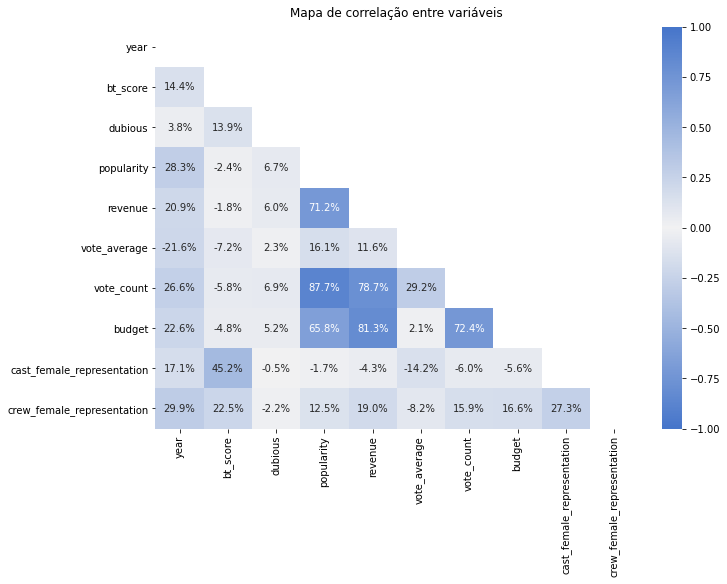

In [24]:
fig, axs = plt.subplots(figsize=(10, 8), constrained_layout=True)


def plot(axs, data, title):
    corr = data.corr(method='spearman')
    cmap = sns.diverging_palette(255, 255, sep=1, as_cmap=True)
    mask = np.triu(np.ones_like(corr, dtype=bool))

    graph = sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt='.1%', cmap=cmap, mask=mask, ax=axs)
    graph.set_title(title, pad=10)


plot(axs, data.drop(['imdbid', 'tmdbId'], axis=1), 'Mapa de correlação entre variáveis')
plt.show()

## **Gráficos simples**

### **Filmes por nota no Teste de Bechdel**
**Métodos utilizados**
- `collections.Counter()`: conta os valores totais das notas de 0 a 3.
- `DataFrame.from_dict(data, orient='index')`: transforma um dicionário em DataFrame. `orient='index'` faz com que as keys do dicionário sejam usadas como index.

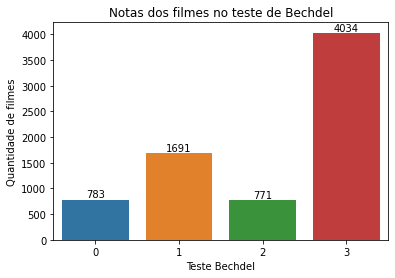

In [25]:
# TOTAL DE FILMES POR NOTA
# score_plot = sns.barplot(x='score', y='total', data=score_df)
score_plot = sns.barplot(x='index', y='bt_score', data=data.bt_score.value_counts().reset_index())
score_plot.bar_label(score_plot.containers[0])
score_plot.set(title='Notas dos filmes no teste de Bechdel')
plt.xlabel("Teste Bechdel")
plt.ylabel("Quantidade de filmes")
plt.show()

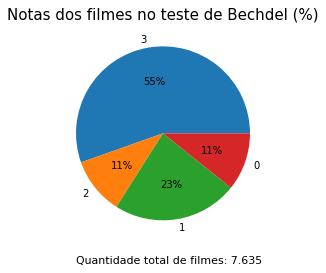

In [26]:
# PORCENTAGEM DOS FILMES
# score_df = df com a quantidade de filmes por nota.
score_df = collections.Counter(data.bt_score)
score_df = pd.DataFrame.from_dict(score_df, orient='index').reset_index()
score_df = score_df.rename(columns={'index': 'score', 0: 'total'})
plt.pie(score_df.total, labels = score_df.score.to_list(), autopct='%.0f%%')
score_df.score.to_list()
plt.text(-1, -1.5, "Quantidade total de filmes: 7.635", fontsize=11)
plt.title("Notas dos filmes no teste de Bechdel (%)", fontsize=15)
plt.show()

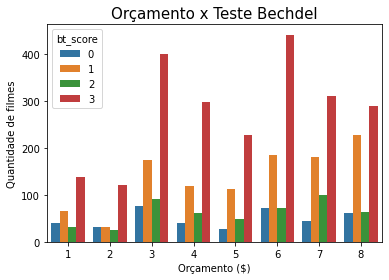

In [27]:
budget_df = data.loc[data['budget'] > 0].copy()

budget_df['Orçamento'] = pd.NA

for index, row in budget_df.iterrows():
    orçamento = 0
    if row['budget'] <= 500000:
        orçamento += 1
    if row['budget'] <= 1000000 and row['budget'] > 500000:
        orçamento += 2
    if row['budget'] <= 5000000 and row['budget'] > 1000000:
        orçamento += 3
    if row['budget'] <= 10000000 and row['budget'] > 5000000:
        orçamento += 4
    if row['budget'] <= 15000000 and row['budget'] > 10000000:
        orçamento += 5
    if row['budget'] <= 30000000 and row['budget'] > 15000000:
        orçamento += 6
    if row['budget'] <= 60000000 and row['budget'] > 30000000:
        orçamento += 7
    if row['budget'] > 60000000:
        orçamento += 8
    budget_df.loc[index, 'Orçamento'] = orçamento

sns.countplot(x ='Orçamento', hue = 'bt_score', data = budget_df)
plt.title("Orçamento x Teste Bechdel", fontsize=15)
plt.xlabel("Orçamento ($)")
plt.ylabel("Quantidade de filmes")
plt.show()

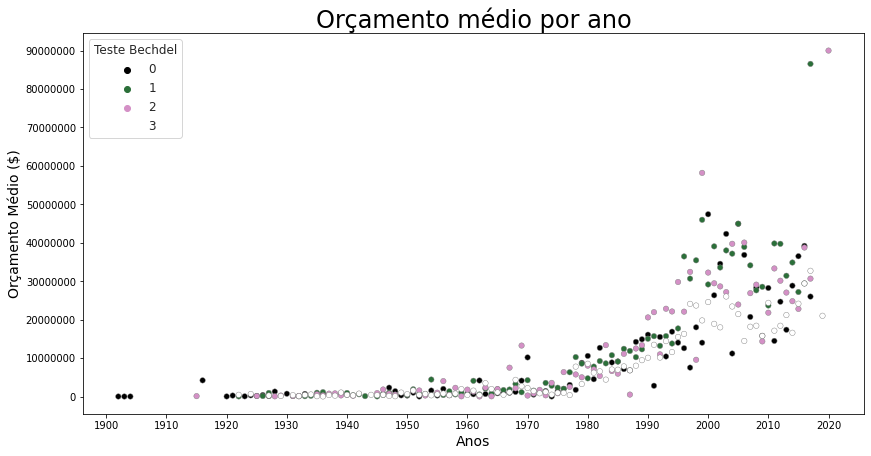

In [28]:
budget_year_mean = data.groupby(['year', 'bt_score'])['budget'].mean().to_frame().reset_index()
budget_year_mean1 = budget_year_mean[budget_year_mean['budget'] > 0]
budget_year_mean2 = budget_year_mean1[budget_year_mean1['year'] >= 1902]
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = 'budget', x = 'year', hue = 'bt_score', data=budget_year_mean2, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Orçamento Médio ($)", size = 14) 
ax.set_title("Orçamento médio por ano", size = 24) 
ax.set_xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

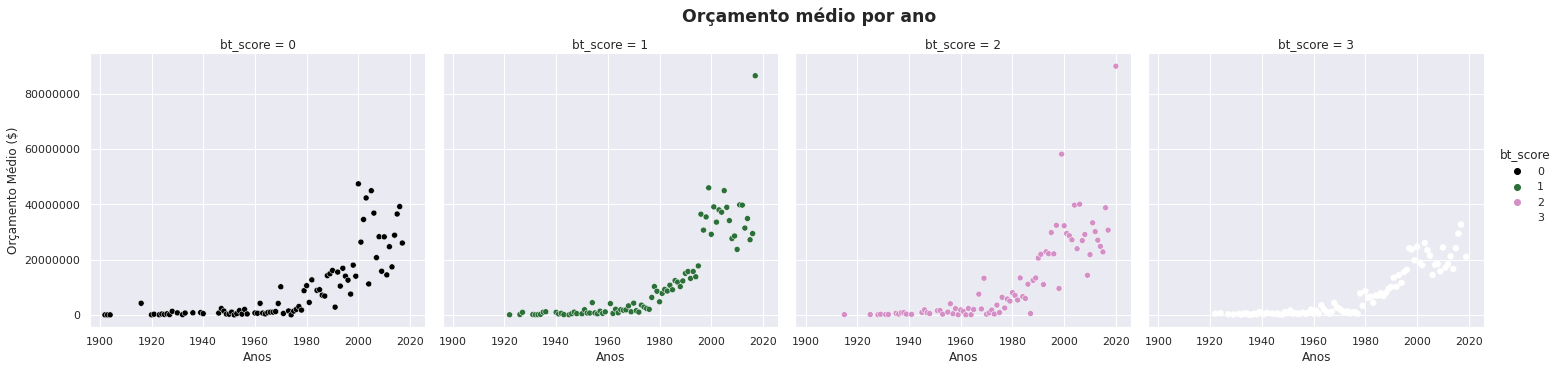

In [29]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 12}) 
g = sns.relplot(data = budget_year_mean2, x = "year",  y = "budget", col = "bt_score", hue = "bt_score", palette="cubehelix") 
g.fig.suptitle("Orçamento médio por ano", fontsize = 'x-large', fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Orçamento Médio ($)") 
plt.ticklabel_format(style='plain', axis='y')
plt.show()

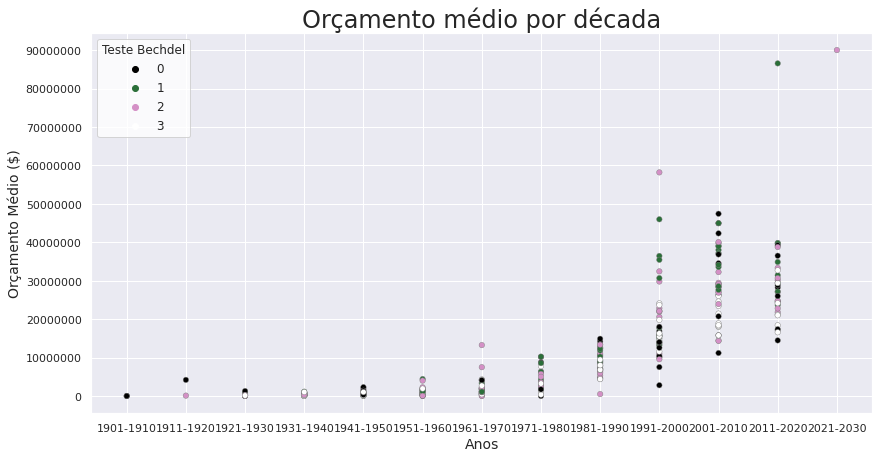

In [30]:
budget_interval_mean = data.groupby(['year', 'bt_score'])['budget'].mean().to_frame().reset_index()
budget_interval_mean1 = budget_interval_mean[budget_interval_mean['budget'] > 0]
budget_interval_mean2 = budget_interval_mean1[budget_interval_mean1['year'] >= 1902]

for index, year in budget_interval_mean2['year'].iteritems():
    interval_start = int(year - year % 10 + 1)
    interval_end = int(interval_start + 9)
    budget_interval_mean2.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)
    
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = 'budget', x = 'year_interval', hue = 'bt_score', data=budget_interval_mean2, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Orçamento Médio ($)", size = 14) 
ax.set_title("Orçamento médio por década", size = 24) 
ax.set_yticks([0, 10000000, 20000000, 30000000, 40000000, 50000000, 60000000, 70000000, 80000000, 90000000])
plt.ticklabel_format(style='plain', axis='y')

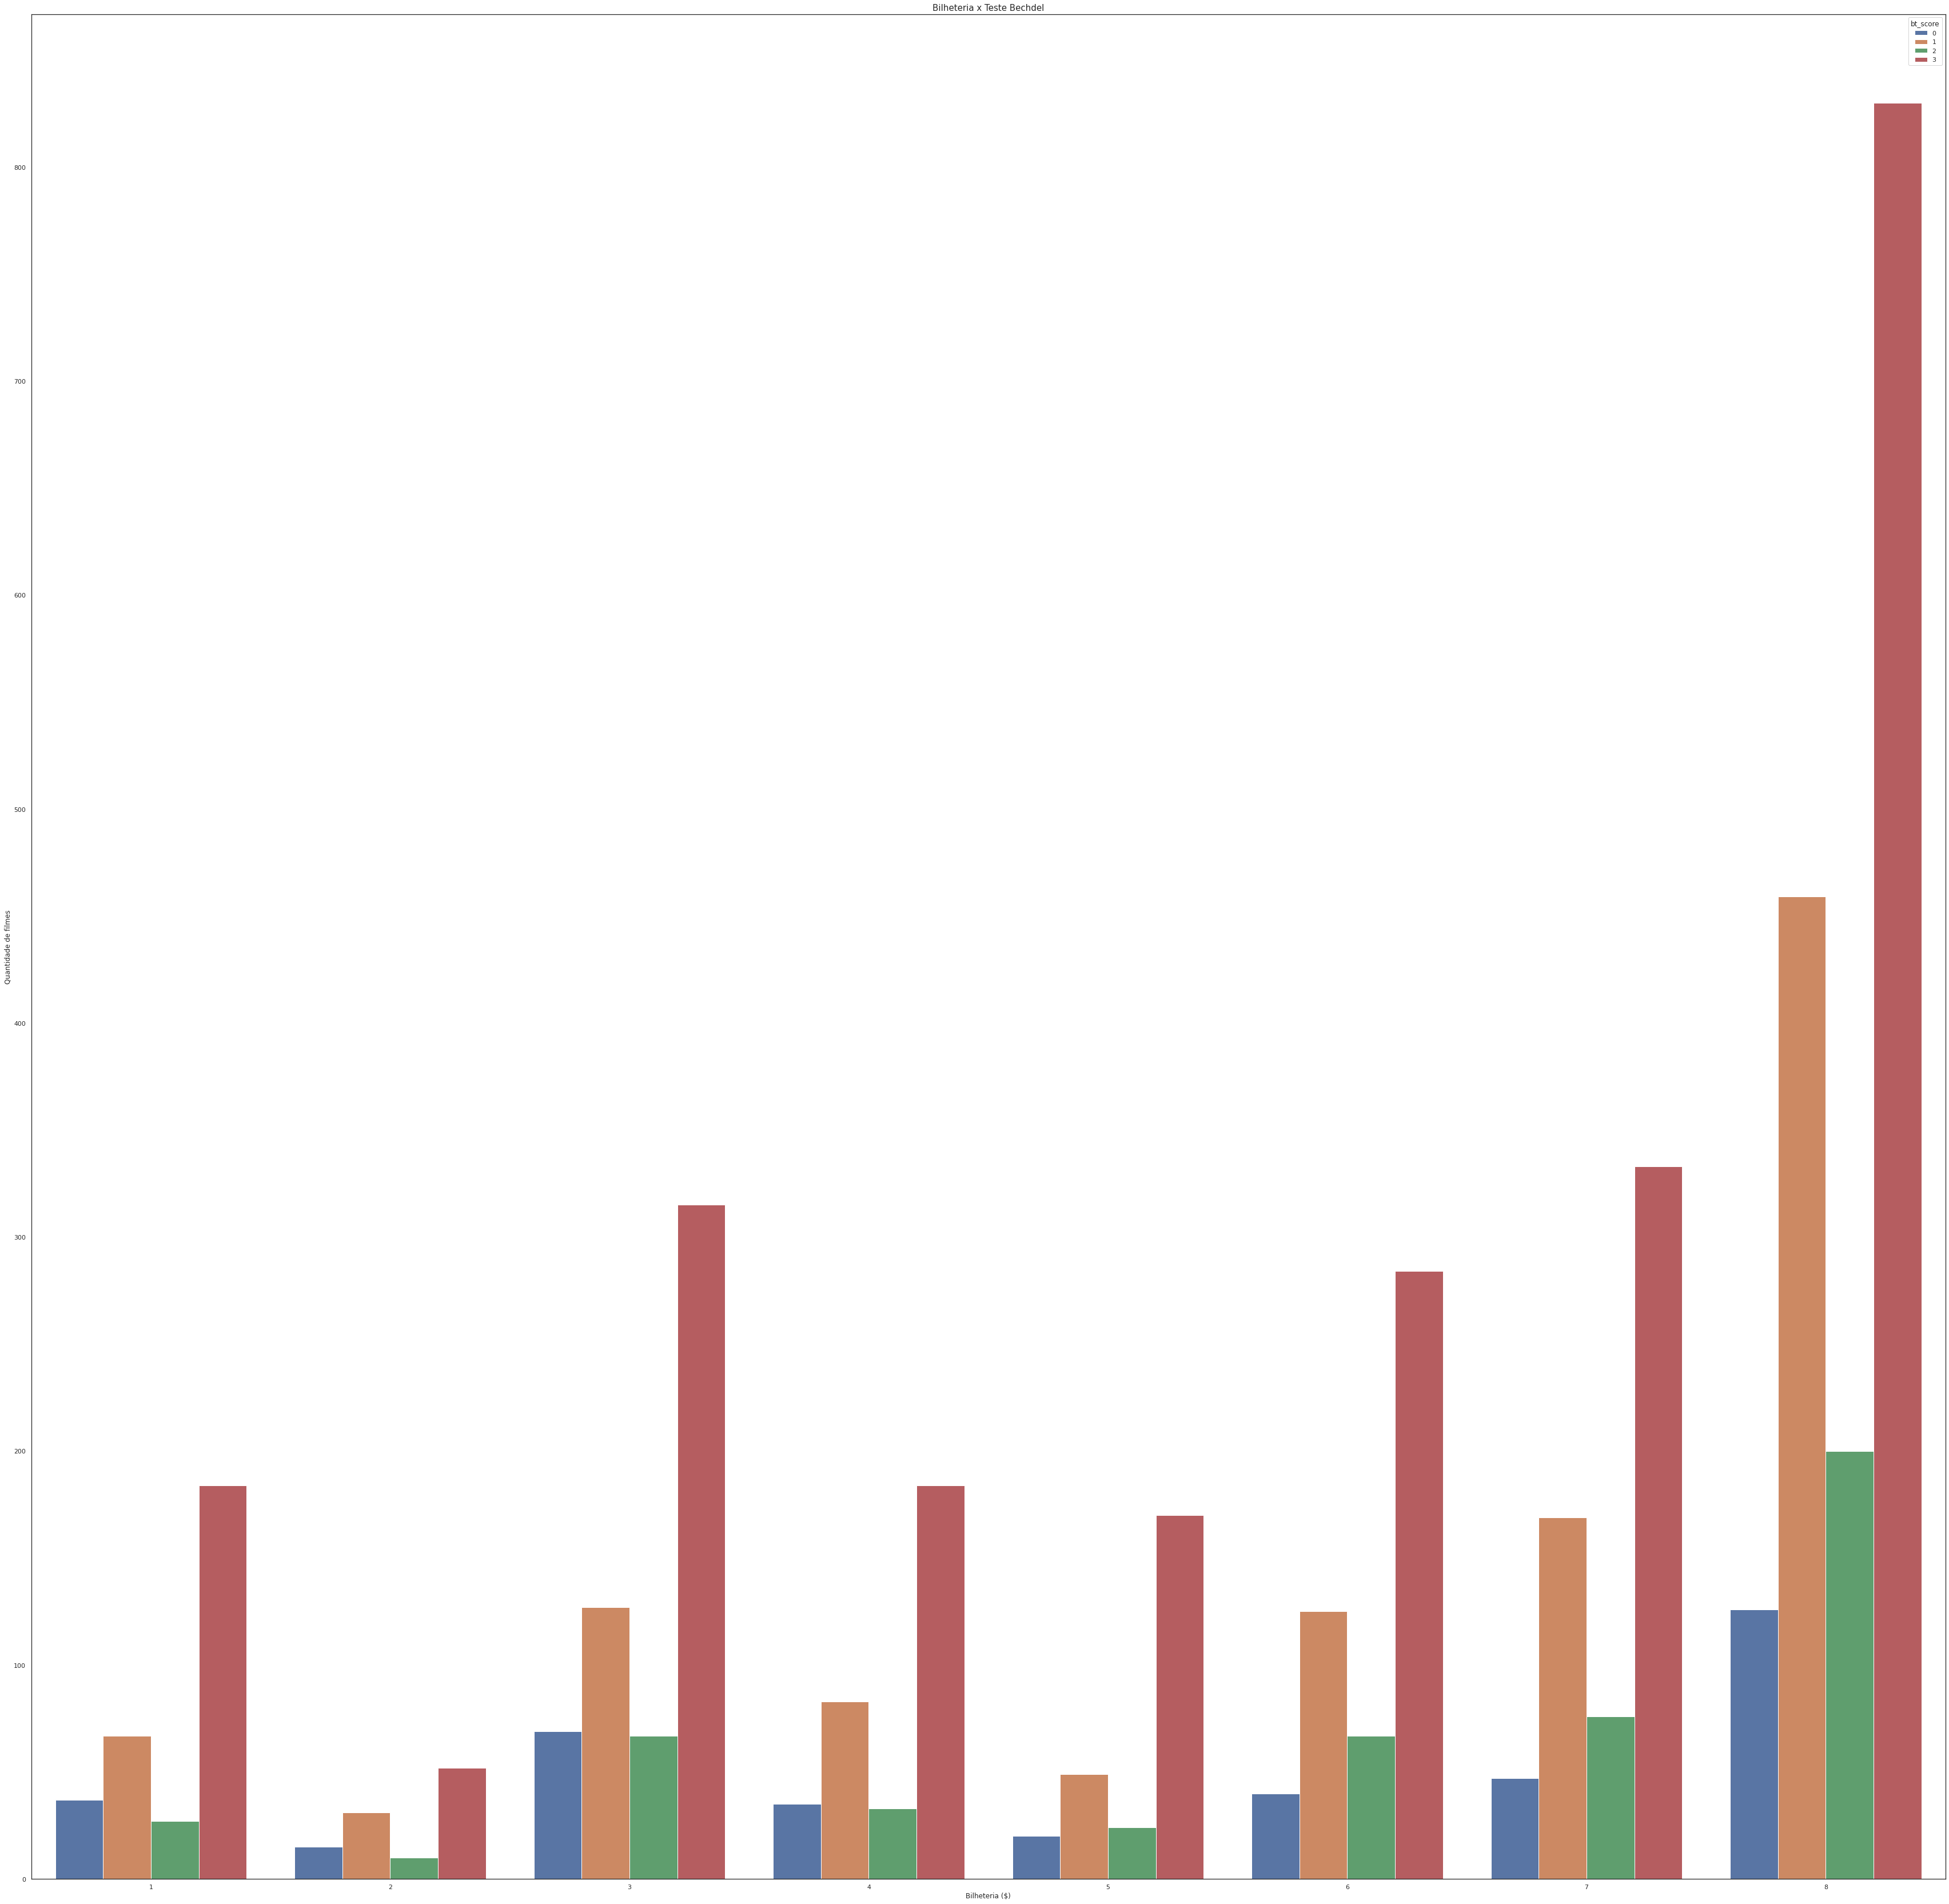

In [31]:
revenue_df = data.loc[data['revenue'] > 0].copy()

revenue_df['Bilheteria'] = pd.NA

for index, row in revenue_df.iterrows():
    bilheteria = 0
    if row['revenue'] <= 500000:
        bilheteria += 1
    if row['revenue'] <= 1000000 and row['revenue'] > 500000:
        bilheteria += 2
    if row['revenue'] <= 5000000 and row['revenue'] > 1000000:
        bilheteria += 3
    if row['revenue'] <= 10000000 and row['revenue'] > 5000000:
        bilheteria += 4
    if row['revenue'] <= 15000000 and row['revenue'] > 10000000:
        bilheteria += 5
    if row['revenue'] <= 30000000 and row['revenue'] > 15000000:
        bilheteria += 6
    if row['revenue'] <= 60000000 and row['revenue'] > 30000000:
        bilheteria += 7
    if row['revenue'] > 60000000:
        bilheteria += 8
    revenue_df.loc[index, 'Bilheteria'] = bilheteria

sns.countplot(x ='Bilheteria', hue = 'bt_score', data = revenue_df)
plt.title("Bilheteria x Teste Bechdel", fontsize=15)
plt.xlabel("Bilheteria ($)")
plt.ylabel("Quantidade de filmes")
plt.show()

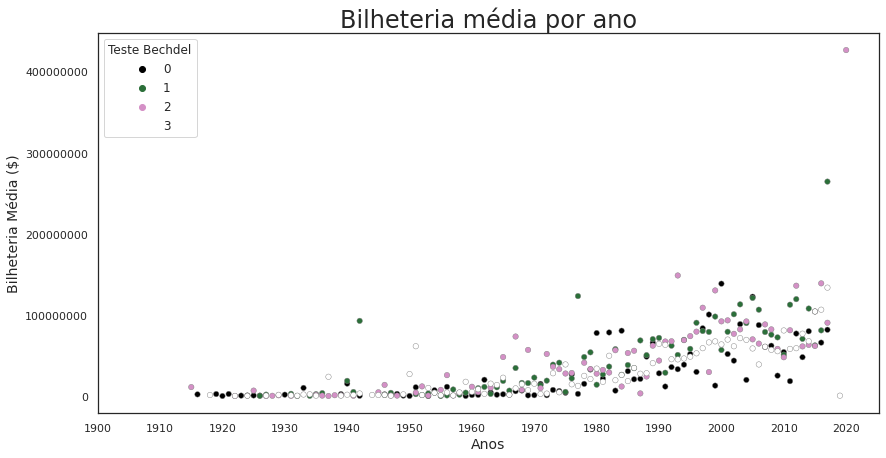

In [32]:
revenue_year_mean = data.groupby(['year', 'bt_score'])['revenue'].mean().to_frame().reset_index()
revenue_year_mean1 = revenue_year_mean[revenue_year_mean['revenue'] > 0]
revenue_year_mean2 = revenue_year_mean1[revenue_year_mean1['year'] >= 1902]
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = 'revenue', x = 'year', hue = 'bt_score', data=revenue_year_mean2, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Bilheteria Média ($)", size = 14) 
ax.set_title("Bilheteria média por ano", size = 24) 
ax.set_xticks([1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

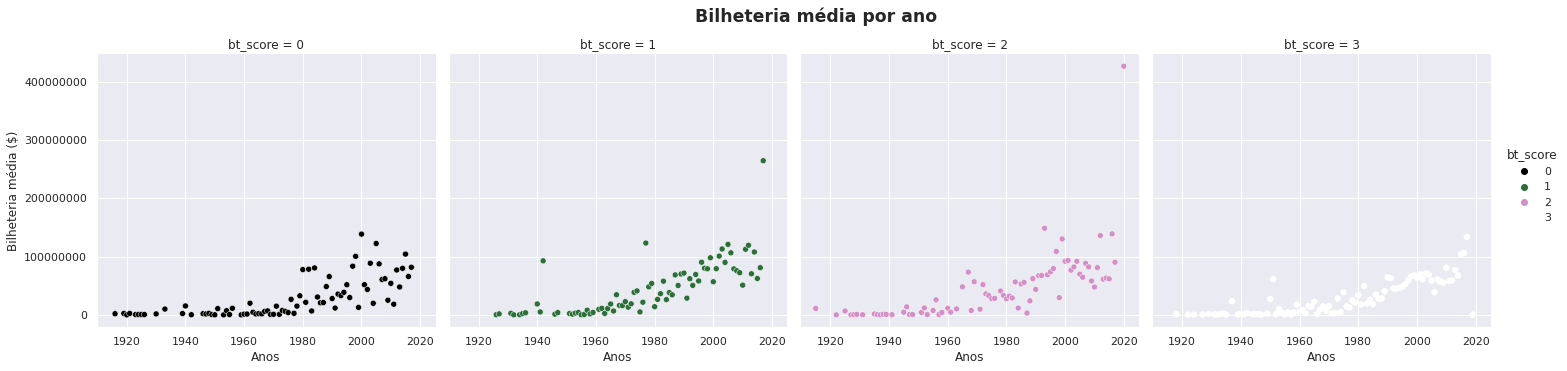

In [33]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 12}) 
g = sns.relplot(data = revenue_year_mean2, x = "year",  y = "revenue", col = "bt_score", hue = "bt_score", palette="cubehelix") 
g.fig.suptitle("Bilheteria média por ano", fontsize = 'x-large', fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Bilheteria média ($)") 
plt.ticklabel_format(style='plain', axis='y') 
plt.show()

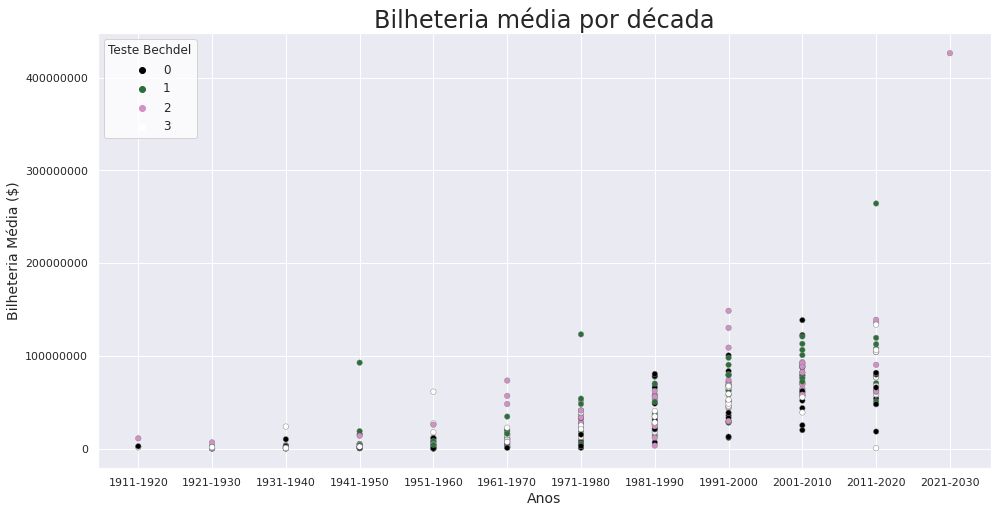

In [34]:
revenue_interval_mean = data.groupby(['year', 'bt_score'])['revenue'].mean().to_frame().reset_index()
revenue_interval_mean1 = revenue_interval_mean[revenue_interval_mean['revenue'] > 0]
revenue_interval_mean2 = revenue_interval_mean1[revenue_interval_mean1['year'] >= 1902]

for index, year in revenue_interval_mean2['year'].iteritems():
    interval_start = int(year - year % 10 + 1)
    interval_end = int(interval_start + 9)
    revenue_interval_mean2.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)
    
fig, ax = plt.subplots(figsize = (16 , 8))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = 'revenue', x = 'year_interval', hue = 'bt_score', data=revenue_interval_mean2, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Bilheteria Média ($)", size = 14) 
ax.set_title("Bilheteria média por década", size = 24) 
plt.ticklabel_format(style='plain', axis='y')
plt.show()

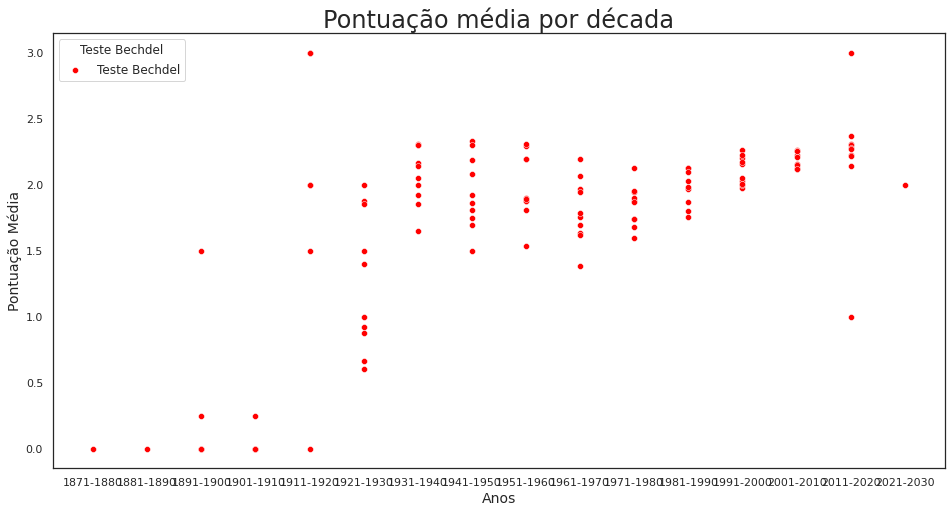

In [35]:
bechdel_year_mean = data.groupby(['year'])['bt_score'].mean().to_frame().reset_index()
for index, year in bechdel_year_mean['year'].iteritems():
    interval_start = int(year - year % 10 + 1)
    interval_end = int(interval_start + 9)
    bechdel_year_mean.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)
fig, ax = plt.subplots(figsize = (16 , 8))
sns.set_style("white")
sns.scatterplot(data=bechdel_year_mean, x="year_interval", y="bt_score", color = "red", ci=None)
plt.legend(labels = ['Teste Bechdel'], title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Pontuação Média", size = 14) 
ax.set_title("Pontuação média por década", size = 24)
plt.show()

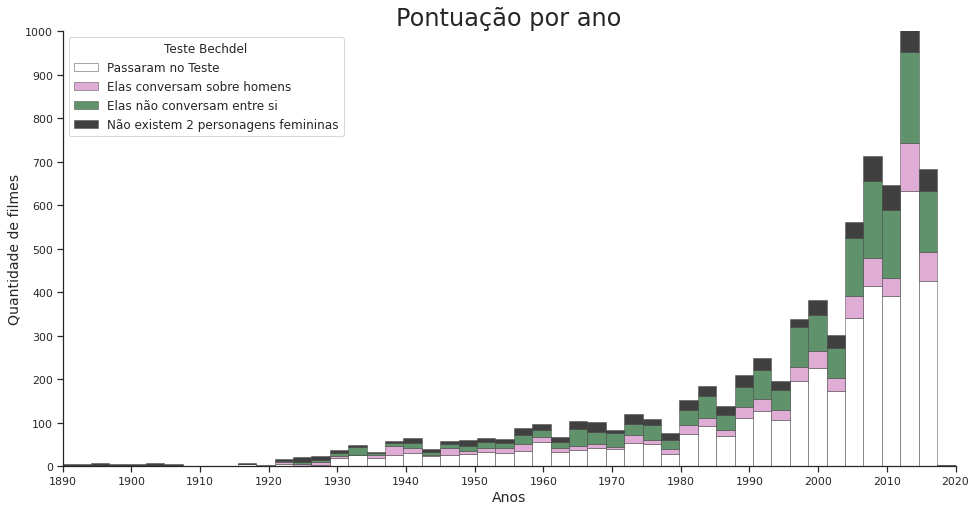

In [36]:
import matplotlib as mpl
    
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(16, 8))
sns.despine(f)
sns.histplot(data, x="year", hue="bt_score", multiple="stack", palette="cubehelix", edgecolor=".3", linewidth=.5)
plt.legend(labels = ["Passaram no Teste", "Elas conversam sobre homens", "Elas não conversam entre si", "Não existem 2 personagens femininas"], 
           title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Quantidade de filmes", size = 14) 
ax.set_title("Pontuação por ano", size = 24) 
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
ax.set_xlim(1890, 2020)
ax.set_ylim(0, 1000)
plt.show()

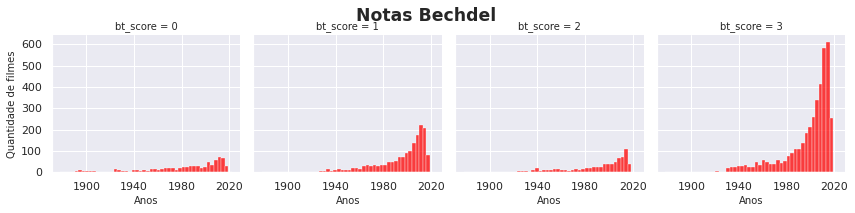

In [37]:
sns.set_theme(style="darkgrid")
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 10}) 
g = sns.displot(data, x="year", col="bt_score", binwidth=3, height=3, facet_kws=dict(margin_titles=True), color = 'red')
g.set(xticks=(1900, 1940, 1980, 2020), yticks=(0, 100, 200, 300, 400, 500, 600))
g.fig.suptitle("Notas Bechdel", fontsize = 'x-large', fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Quantidade de filmes")
plt.show()

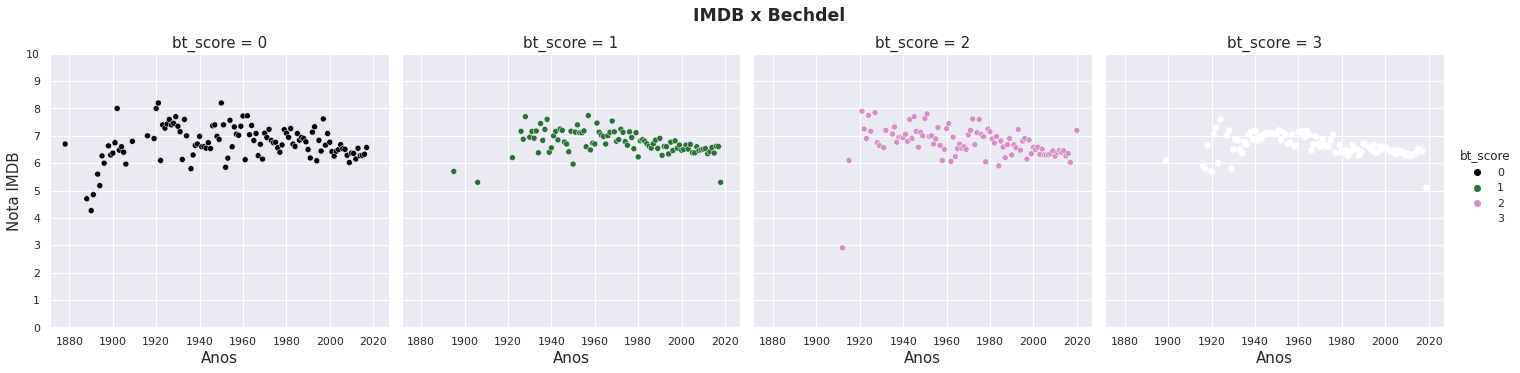

In [38]:
imdb_bechdel = data.groupby(['year', 'bt_score'])['vote_average'].mean().to_frame().reset_index()
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 15}) 
g = sns.relplot(data = imdb_bechdel, x = "year",  y = "vote_average", col = "bt_score", hue = "bt_score", palette="cubehelix") 
g.fig.suptitle("IMDB x Bechdel", fontsize = 'x-large', fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Nota IMDB") 
g.set(ylim=(0, 10))
g.set(yticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
plt.show()

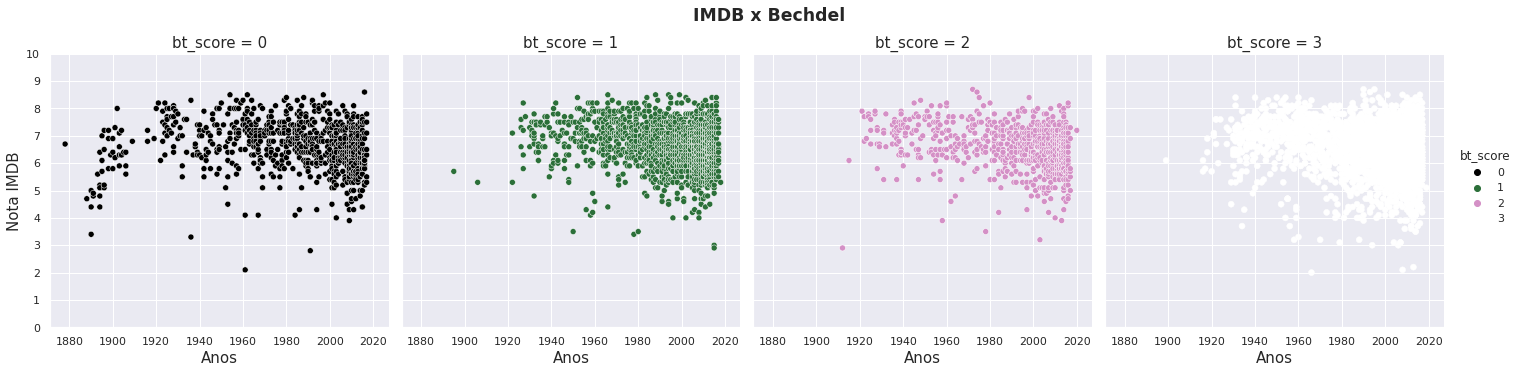

In [39]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 15}) 
g = sns.relplot(data = data, x = "year",  y = "vote_average", col = "bt_score", hue = "bt_score", palette="cubehelix") 
g.fig.suptitle("IMDB x Bechdel", fontsize = 'x-large', fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Nota IMDB") 
g.set(ylim=(0, 10))
g.set(yticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
plt.show()

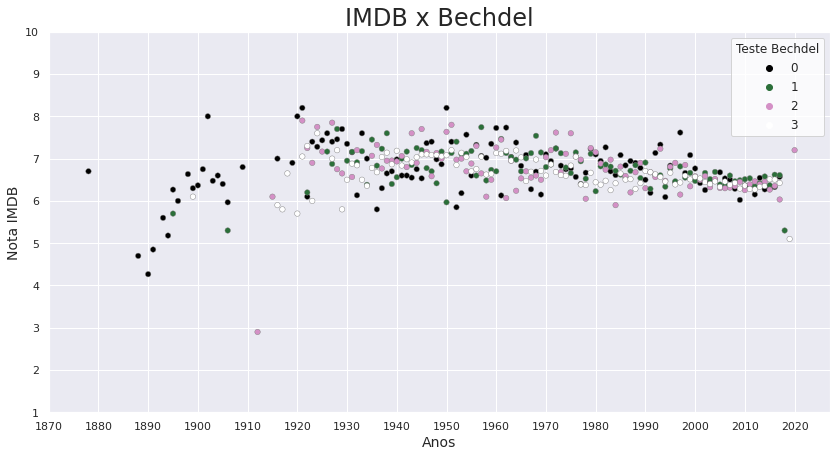

In [40]:
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = "vote_average", x = 'year', hue = 'bt_score', data=imdb_bechdel, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Nota IMDB", size = 14) 
ax.set_title("IMDB x Bechdel", size = 24) 
ax.set_xticks([1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

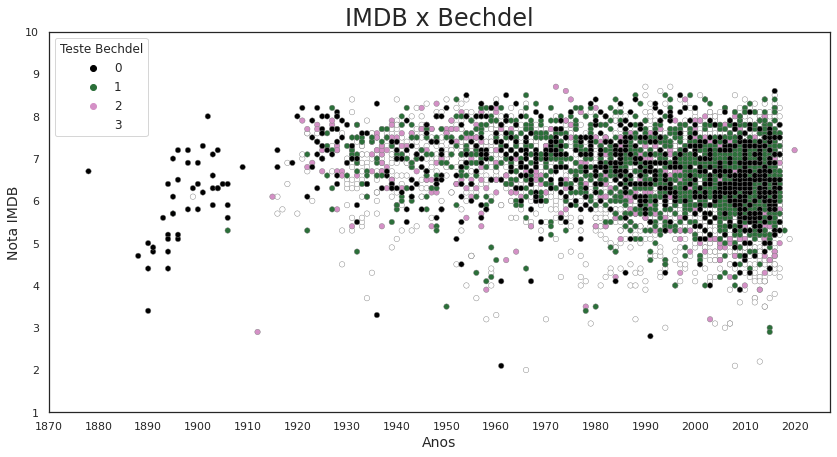

In [41]:
fig, ax = plt.subplots(figsize = (14 , 7))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = "vote_average", x = 'year', hue = 'bt_score', data=data, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Nota IMDB", size = 14) 
ax.set_title("IMDB x Bechdel", size = 24) 
ax.set_xticks([1870, 1880, 1890, 1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

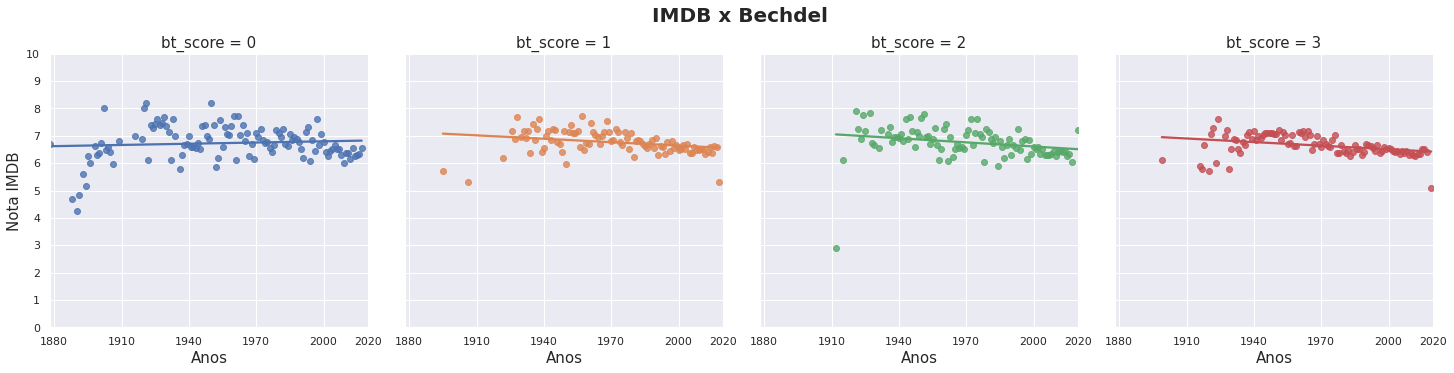

In [42]:
sns.set( rc = {'figure.figsize': (60, 60), 'axes.labelsize': 15})  
g = sns.lmplot(x = 'year', y = "vote_average", hue = 'bt_score', col = 'bt_score', data = imdb_bechdel, ci = None)
g.fig.suptitle("IMDB x Bechdel", fontsize = 20, fontweight = 'bold') 
g.fig.subplots_adjust(top = 0.85) 
g.set_axis_labels("Anos" , "Nota IMDB") 
g.set(ylim=(0, 10))
g.set(xticks=(1880, 1910, 1940, 1970, 2000, 2020), yticks=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
plt.show()

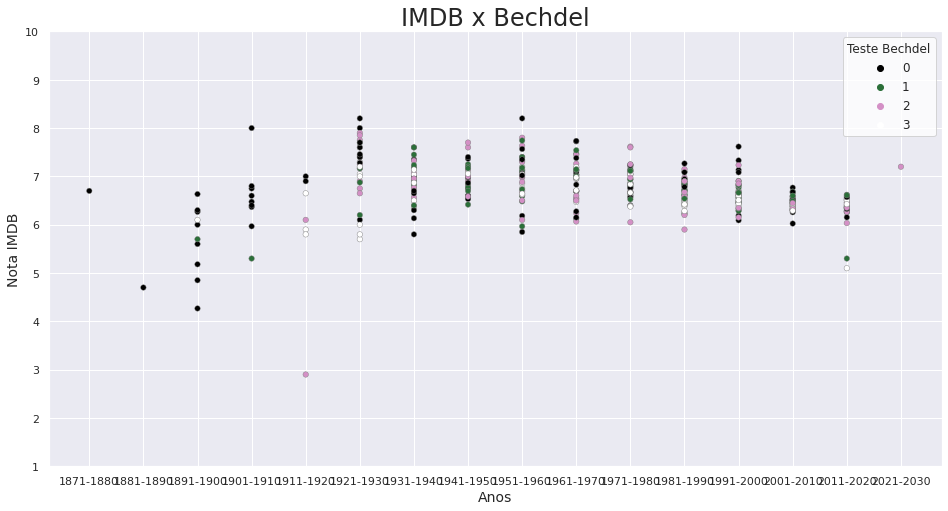

In [43]:
for index, year in imdb_bechdel['year'].iteritems():
    interval_start = int(year - year % 10 + 1)
    interval_end = int(interval_start + 9)
    imdb_bechdel.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)

fig, ax = plt.subplots(figsize = (16 , 8))
sns.set_theme(style="ticks")
sns.set_style("white")
sns.scatterplot(y = "vote_average", x = 'year_interval', hue = 'bt_score', data=imdb_bechdel, palette="cubehelix", s = 30, edgecolor=".5")
plt.legend(title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Anos", size = 14) 
ax.set_ylabel("Nota IMDB", size = 14) 
ax.set_title("IMDB x Bechdel", size = 24) 
ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.ticklabel_format(style='plain', axis='y')
plt.show()

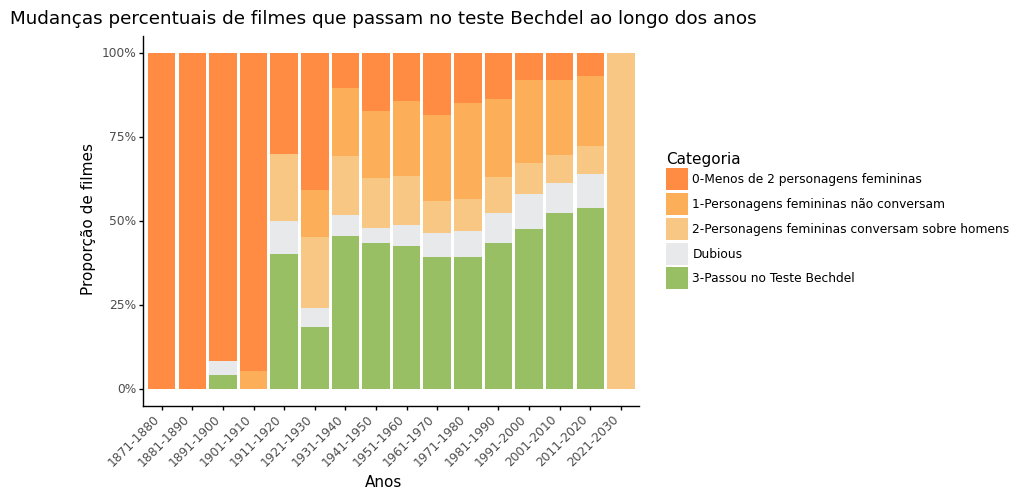

<ggplot: (8757300248555)>

In [44]:
data2_df = data.copy()

for index, bt_score in data2_df['bt_score'].iteritems():
    if bt_score == 0:
        if data2_df.at[index, 'dubious'] == 1:
            data2_df.at[index, 'Categoria'] = 'Dubious'
        else:
            data2_df.at[index, 'Categoria'] = '0-Menos de 2 personagens femininas'
    elif bt_score == 1:
        if data2_df.at[index, 'dubious'] == 1:
            data2_df.at[index, 'Categoria'] = 'Dubious'
        else:
            data2_df.at[index, 'Categoria'] = '1-Personagens femininas não conversam'
    elif bt_score == 2:
        if data2_df.at[index, 'dubious'] == 1:
            data2_df.at[index, 'Categoria'] = 'Dubious'
        else:
            data2_df.at[index, 'Categoria'] = '2-Personagens femininas conversam sobre homens'
    else:
        if data2_df.at[index, 'dubious'] == 1:
            data2_df.at[index, 'Categoria'] = 'Dubious'
        else:
            data2_df.at[index, 'Categoria'] = '3-Passou no Teste Bechdel'
            
bechdel_df_ordered = data2_df.copy()
bechdel_df_ordered['Categoria'] = pd.Categorical(bechdel_df_ordered['Categoria'], categories=[
    '0-Menos de 2 personagens femininas', 
    '1-Personagens femininas não conversam',
    '2-Personagens femininas conversam sobre homens',
    'Dubious',
    '3-Passou no Teste Bechdel'
], ordered=True)

for index, year in bechdel_df_ordered['year'].iteritems():
    interval_start = int(year - year % 10 + 1)
    interval_end = int(interval_start + 9)
    bechdel_df_ordered.at[index, 'year_interval'] = str(interval_start) + '-' + str(interval_end)

(ggplot(bechdel_df_ordered, 
        aes(fill = 'Categoria', x = 'year_interval')) + 
    geom_bar(position = "fill") + 
    scale_y_continuous(labels=percent_format()) +
    scale_fill_manual(values = ['#FF8C42', '#FCAF58', '#F9C784', '#E8E9EB', '#98BF64']) +
    # geom_text(angle=45) + 
    labs(
        title = 'Mudanças percentuais de filmes que passam no teste Bechdel ao longo dos anos', 
        subtitle = 'Gráfico de barras de porcentagem empilhada',
        x = 'Anos', 
        y = 'Proporção de filmes'
    ) + 
    theme_classic() + 
    theme(axis_text_x  = element_text(angle = 45, hjust = 1))
)

In [45]:
data_clean = pd.read_csv('cleaned_data.csv', index_col=0)
data_clean.head()

,title,year,bt_score,dubious,imdbid,tmdbId,genres,popularity,production_companies,production_countries,...,revenue,vote_average,vote_count,cast,crew,budget,cast_gender,crew_gender,cast_female_representation,crew_female_representation
0,Cinderella,1899,3,0,230,114108,"['Drama', 'Family', 'Fantasy', 'Romance']",3.762,"['Star-Film', 'Georges Méliès']",['France'],...,0.0,6.1,79.0,"[{'adult': False, 'gender': 2, 'id': 11523, 'k...","[{'adult': False, 'gender': 2, 'id': 11523, 'k...",0.0,"[2, 0, 1, 0, 1, 0]","[2, 2, 2, 2]",33.333333,0.000000
1,Gretchen the Greenhorn,1916,3,0,6745,126925,[],1.942,[],[],...,0.0,6.1,7.0,"[{'adult': False, 'gender': 1, 'id': 30779, 'k...","[{'adult': False, 'gender': 2, 'id': 42060, 'k...",0.0,"[1, 2, 2, 2]","[2, 2, 2]",25.000000,0.000000
2,Snow White,1916,3,0,7361,174598,"['Fantasy', 'Drama']",0.817,[],[],...,0.0,5.7,9.0,"[{'adult': False, 'gender': 0, 'id': 1658947, ...","[{'adult': False, 'gender': 2, 'id': 28968, 'k...",0.0,"[0, 1, 2, 2, 0]",[2],20.000000,0.000000
3,The Poor Little Rich Girl,1917,3,0,8443,95866,"['Romance', 'Comedy', 'Drama', 'Fantasy']",2.023,['Artcraft Pictures Corporation'],['United States of America'],...,0.0,5.8,23.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 2, 'id': 13335, 'k...",0.0,"[1, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 1, 1]","[2, 2, 1, 1, 2, 2, 0]",38.461538,28.571429
4,Stella Maris,1918,3,0,9652,70753,['Drama'],1.310,['Mary Pickford Company'],['United States of America'],...,2400000.0,6.9,19.0,"[{'adult': False, 'gender': 1, 'id': 100047, '...","[{'adult': False, 'gender': 1, 'id': 34741, 'k...",0.0,"[1, 1, 2, 2, 1, 0, 0, 2]","[1, 2, 2, 0, 2, 2]",37.500000,16.666667


In [46]:
teste = eval(data_clean.genres[0])
teste[3]

'Romance'

In [47]:
#- procurar onde ta a virgula ler ate ela
#- adicionar por append a uma lista

In [76]:
data_clean.popularity.max

<bound method Series.max of 0        3.762
1        1.942
2        0.817
3        2.023
4        1.310
         ...  
7630    31.004
7631    17.122
7632    16.294
7633     7.712
7634    12.251
Name: popularity, Length: 7279, dtype: float64>

<AxesSubplot:title={'center':'Bechdel Test score by vote average'}, xlabel='Year'>

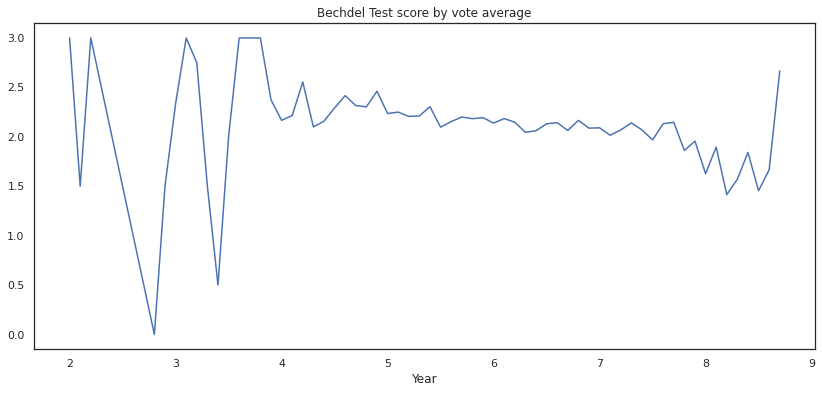

In [49]:
data_clean.groupby('vote_average')['bt_score'].mean().plot(title="Bechdel Test score by vote average",figsize=(14, 6), xlabel="Year")

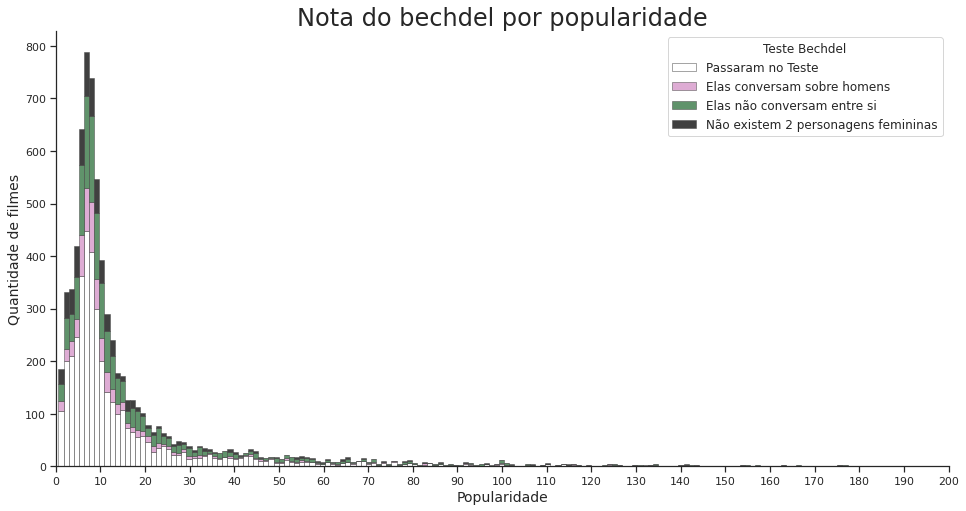

In [87]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(16, 8))
sns.despine(f)
sns.histplot(data, x="popularity", hue="bt_score", multiple="stack", palette="cubehelix", edgecolor=".3", linewidth=.5)
plt.legend(labels = ["Passaram no Teste", "Elas conversam sobre homens", "Elas não conversam entre si", "Não existem 2 personagens femininas"], 
           title = "Teste Bechdel", fontsize = '12', title_fontsize = "12")
ax.set_xlabel("Popularidade", size = 14) 
ax.set_ylabel("Quantidade de filmes", size = 14) 
ax.set_title("Nota do bechdel por popularidade", size = 24) 
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 , 180, 190, 200])
ax.set_xlim(0, 200)
plt.show()